In [134]:
import torch, torchvision
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm
import os, pickle
import common

# Reproducibility
common.set_seed(156)

In [135]:
class NN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(NN, self).__init__()
        self.A = torch.nn.Linear(ni, nh)
        self.relu = torch.nn.ReLU()
        self.B = torch.nn.Linear(nh, no)
    def forward(self, x):
        # Two layer neural network
        x = self.B(self.relu(self.A(x)))
        return x

In [136]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=torchvision.transforms.ToTensor())
# Train data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
# Point estimate NN
net = NN(28*28, 1024, 10)

In [137]:
def model(x, y):
    # Put priors on weights and biases 
    priors = {
        "A.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.weight), 
            scale=torch.ones_like(net.A.weight),
        ).independent(2),
        "A.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.bias), 
            scale=torch.ones_like(net.A.bias),
        ).independent(1),
        "B.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.weight), 
            scale=torch.ones_like(net.B.weight),
        ).independent(2),
        "B.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.bias), 
            scale=torch.ones_like(net.B.bias),
        ).independent(1),
    }
    # Create a NN module using the priors
    lmodule = pyro.random_module("module", net, priors)
    regressor = lmodule()
    # Do a forward pass on the NN module, i.e. yhat=f(x) and condition on yhat=y
    lhat = torch.nn.LogSoftmax(dim=1)(regressor(x))
    pyro.sample("obs", pyro.distributions.Categorical(logits=lhat).independent(1), obs=y)

In [138]:
softplus = torch.nn.Softplus()
def guide(x, y):
    # Create parameters for variational distribution priors
    Aw_mu = pyro.param("Aw_mu", torch.randn_like(net.A.weight))
    Aw_sigma = softplus(pyro.param("Aw_sigma", torch.randn_like(net.A.weight)))
    Ab_mu = pyro.param("Ab_mu", torch.randn_like(net.A.bias))
    Ab_sigma = softplus(pyro.param("Ab_sigma", torch.randn_like(net.A.bias)))
    Bw_mu = pyro.param("Bw_mu", torch.randn_like(net.B.weight))
    Bw_sigma = softplus(pyro.param("Bw_sigma", torch.randn_like(net.B.weight)))
    Bb_mu = pyro.param("Bb_mu", torch.randn_like(net.B.bias))
    Bb_sigma = softplus(pyro.param("Bb_sigma", torch.randn_like(net.B.bias)))
    # Create random variables similarly to model
    priors = {
        "A.weight": pyro.distributions.Normal(loc=Aw_mu, scale=Aw_sigma).independent(2),
        "A.bias"  : pyro.distributions.Normal(loc=Ab_mu, scale=Ab_sigma).independent(1),
        "B.weight": pyro.distributions.Normal(loc=Bw_mu, scale=Bw_sigma).independent(2),
        "B.bias"  : pyro.distributions.Normal(loc=Bb_mu, scale=Bb_sigma).independent(1),
    }
    # Return NN module from these random variables
    lmodule = pyro.random_module("module", net, priors)
    return lmodule()

In [139]:
# Do stochastic variational inference to find q(w) closest to p(w|D)
svi = pyro.infer.SVI(
    model, guide, pyro.optim.Adam({'lr': 0.01}), pyro.infer.Trace_ELBO(),
)

In [140]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with SVI
    for epoch in range(epochs):
        loss = 0.
        for data in train_loader:
            images, labels = data
            images = images.view(-1, 28*28)
            loss += svi.step(images, labels)
        loss /= len(train_loader.dataset)
        print("Epoch %g: Loss = %g" % (epoch, loss))
    # Sample k models from the posterior
    sampled_models = [guide(None, None) for i in range(K)]
    # Save the models
    nn_dicts = []
    for i in range(len(sampled_models)):
        nn_dicts += [sampled_models[i].state_dict()]
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [141]:
def load_models(K = 100, model_dir="models/model.pt"):
    # Load the models
    sampled_models = [NN(28*28, 1024, 10) for i in range(K)]
    for net, state_dict in zip(sampled_models, torch.load(model_dir)):
        net.load_state_dict(state_dict)
    print("Loaded %d sample models" % K)
    return sampled_models

train_and_save_models(epochs = 10, K = 100, modelname = "model.pt")

## Evaluate Accuracy

### Load Test Sets

In [142]:
dirs = [d for d in os.listdir("mnist_adv/") if "test_images_med" in d]

images  = []
targets = []
for d in dirs:
    with open("mnist_adv/"+d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
targets = torch.hstack(targets)

In [143]:
# Test dataset
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())

# Test data loader with batch_size 128
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True,
                                         generator=torch.Generator().manual_seed(156))

# AdvTest dataset
adv_test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())
adv_test_dataset.data    = None
adv_test_dataset.targets = None

adv_test_dataset.data    = images
adv_test_dataset.targets = targets

# Test data loader with batch_size 1
adv_test_loader = torch.utils.data.DataLoader(adv_test_dataset, batch_size=128, shuffle=True,
                                         generator=torch.Generator().manual_seed(156))

### Evaluate

In [144]:
class NN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(NN, self).__init__()
        self.A = torch.nn.Linear(ni, nh)
        self.relu = torch.nn.ReLU()
        self.B = torch.nn.Linear(nh, no)
        self.logsoftmax = torch.nn.LogSoftmax(dim=-1)
    def forward(self, x):
        # Two layer neural network
        x = self.B(self.relu(self.A(x)))
        x = self.logsoftmax(x)
        return x
class DeepNN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(DeepNN, self).__init__()
        self.fwd = torch.nn.Sequential(
            torch.nn.Linear(ni, nh), torch.nn.ReLU(),
            torch.nn.Linear(nh, nh), torch.nn.ReLU(),
            torch.nn.Linear(nh, no),
            torch.nn.LogSoftmax(dim=-1))
    def forward(self, x):
        # Two layer neural network
        x = self.fwd(x)
        return x
class DeepNNwBN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(DeepNNwBN, self).__init__()
        self.fwd = torch.nn.Sequential(
            torch.nn.BatchNorm1d(ni),
            torch.nn.Linear(ni, nh), torch.nn.ReLU(),
            torch.nn.BatchNorm1d(nh),
            torch.nn.Linear(nh, nh), torch.nn.ReLU(),
            torch.nn.BatchNorm1d(nh),
            torch.nn.Linear(nh, no),
            torch.nn.LogSoftmax(dim=-1))
    def forward(self, x):
        # Two layer neural network
        x = self.fwd(x)
        return x

In [145]:
def evaluate_accuracy(model, loader):
    total_correct = 0
    for data in loader:
        images, labels = data
        images = images.view(-1, 28*28)
        y    = model(images)
        pred = torch.argmax(y, dim=1)
        total_correct += torch.sum(pred==labels).item()
    return total_correct / len(loader.dataset.targets)

In [146]:
FFNN          = torch.load("models/FFNN_ep10.pt")
AdvFFNN       = torch.load("models/AdvFFNN_eps0.05_ep10.pt")
AdvFFNN_eps18 = torch.load("models/AdvFFNN_eps0.18_ep10.pt")

In [147]:
AdvDeepFFNN_eps18    = torch.load("models/AdvDeepFFNN_eps0.18_loss0.00108.pt")
AdvDeepFFNNwBN_eps18 = torch.load("models/AdvDeepFFNNwBN_eps0.18_loss0.00065.pt")

### FFNN vs AdvFFNN

#### Test

In [148]:
evaluate_accuracy(FFNN, test_loader)

0.9741

In [149]:
evaluate_accuracy(AdvFFNN, test_loader)

0.9742

In [150]:
evaluate_accuracy(AdvFFNN_eps18, test_loader)

0.9681

In [151]:
evaluate_accuracy(AdvDeepFFNNwBN_eps18, test_loader)

0.9788

##### Adversarial

In [152]:
evaluate_accuracy(FFNN, adv_test_loader)

0.8545735677083334

In [153]:
evaluate_accuracy(AdvFFNN, adv_test_loader)

0.8892415364583334

In [154]:
evaluate_accuracy(AdvFFNN_eps18, adv_test_loader)

0.9817708333333334

In [155]:
evaluate_accuracy(AdvDeepFFNNwBN_eps18, adv_test_loader)

0.9935709635416666

### AdvBNN vs BNN

In [161]:
sampled_models         = load_models(K = 50)
sampled_adv_models     = load_models(K = 50, model_dir="models/AdvBNN_eps0.05_85.081.pt")
sampled_adv_models_e18 = load_models(K = 50, model_dir="models/AdvBNN_eps0.18_87.381.pt")

Loaded 50 sample models
Loaded 50 sample models
Loaded 50 sample models


#### AdvBNN(eps=0.05) vs Test

In [162]:
accs = [evaluate_accuracy(model, test_loader) for model in sampled_adv_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.8216
mean:  0.772208 , sd:  0.0256
min:  0.7098


#### AdvBNN(eps=18) vs Test

In [163]:
accs = [evaluate_accuracy(model, test_loader) for model in sampled_adv_models_e18]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.813
mean:  0.7480020000000002 , sd:  0.033
min:  0.6639


#### BNN vs Test

In [164]:
accs = [evaluate_accuracy(model, test_loader) for model in sampled_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.8345
mean:  0.7660100000000001 , sd:  0.0372
min:  0.6509


#### AdvBNN(eps=0.05) vs Adv Test

In [165]:
accs = [evaluate_accuracy(model, adv_test_loader) for model in  sampled_adv_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.4938151041666667
mean:  0.41070475260416667 , sd:  0.0476
min:  0.2970377604166667


#### AdvBNN(eps=0.18) vs Adv Test

In [166]:
accs = [evaluate_accuracy(model, adv_test_loader) for model in  sampled_adv_models_e18]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.5582682291666666
mean:  0.4850781249999999 , sd:  0.0425
min:  0.384521484375


#### BNN vs. Adv Test

In [167]:
accs = [evaluate_accuracy(model, adv_test_loader) for model in  sampled_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.42919921875
mean:  0.28287109375 , sd:  0.0808
min:  0.1669921875


## Adversarial Test (eps=0.18)

In [168]:
dirs = [d for d in os.listdir("mnist_adv_eps0.05/") if "test_images_med" in d]

images  = []
targets = []
for d in dirs:
    with open("mnist_adv_eps0.05/"+d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
targets = torch.hstack(targets)
# Test dataset
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())

# Test data loader with batch_size 128
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True,
                                         generator=torch.Generator().manual_seed(156))

# AdvTest dataset
adv_test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())
adv_test_dataset.data    = None
adv_test_dataset.targets = None

adv_test_dataset.data    = images
adv_test_dataset.targets = targets

# Test data loader with batch_size 1
adv_test_loader = torch.utils.data.DataLoader(adv_test_dataset, batch_size=128, shuffle=True,
                                         generator=torch.Generator().manual_seed(156))

### FFNN vs AdvFFNN

#### Test

In [169]:
evaluate_accuracy(FFNN, test_loader)

0.9741

In [170]:
evaluate_accuracy(AdvFFNN, test_loader)

0.9742

In [171]:
evaluate_accuracy(AdvFFNN_eps18, test_loader)

0.9681

##### Adversarial

In [172]:
evaluate_accuracy(FFNN, adv_test_loader)

0.9907272196261683

In [173]:
evaluate_accuracy(AdvFFNN, adv_test_loader)

0.9914573598130841

In [174]:
evaluate_accuracy(AdvFFNN_eps18, adv_test_loader)

0.9802862149532711

### AdvBNN vs BNN

In [176]:
sampled_models         = load_models(K = 50)
sampled_adv_models     = load_models(K = 50, model_dir="models/AdvBNN_eps0.05_85.081.pt")
sampled_adv_models_e18 = load_models(K = 50, model_dir="models/AdvBNN_eps0.18_87.381.pt")

Loaded 50 sample models
Loaded 50 sample models
Loaded 50 sample models


#### AdvBNN(eps=0.05) vs Test

In [177]:
accs = [evaluate_accuracy(model, test_loader) for model in sampled_adv_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.8216
mean:  0.772208 , sd:  0.0256
min:  0.7098


#### AdvBNN(eps=18) vs Test

In [178]:
accs = [evaluate_accuracy(model, test_loader) for model in sampled_adv_models_e18]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.813
mean:  0.7480020000000002 , sd:  0.033
min:  0.6639


#### BNN vs Test

In [179]:
accs = [evaluate_accuracy(model, test_loader) for model in sampled_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.8345
mean:  0.7660100000000001 , sd:  0.0372
min:  0.6509


#### AdvBNN(eps=0.05) vs Adv Test

In [180]:
accs = [evaluate_accuracy(model, adv_test_loader) for model in  sampled_adv_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.7754088785046729
mean:  0.7058206775700934 , sd:  0.0312
min:  0.6313522196261683


#### AdvBNN(eps=0.18) vs Adv Test

In [181]:
accs = [evaluate_accuracy(model, adv_test_loader) for model in  sampled_adv_models_e18]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.7452540887850467
mean:  0.6823890186915889 , sd:  0.0362
min:  0.584331191588785


#### BNN vs. Adv Test

In [182]:
accs = [evaluate_accuracy(model, adv_test_loader) for model in  sampled_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.7538697429906542
mean:  0.6652745327102805 , sd:  0.0452
min:  0.5505257009345794


## Adversarial Test (FF)

In [183]:
dirs = [d for d in os.listdir("mnist_adv_eps0.05/") if "test_images_FF0.05" in d]

images  = []
targets = []
for d in dirs:
    with open("mnist_adv_eps0.05/"+d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
targets = torch.hstack(targets)
# Test dataset
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())

# Test data loader with batch_size 128
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True,
                                         generator=torch.Generator().manual_seed(156))

# AdvTest dataset
adv_test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())
adv_test_dataset.data    = None
adv_test_dataset.targets = None

adv_test_dataset.data    = images
adv_test_dataset.targets = targets

# Test data loader with batch_size 1
adv_test_loader = torch.utils.data.DataLoader(adv_test_dataset, batch_size=128, shuffle=True,
                                         generator=torch.Generator().manual_seed(156))

### FFNN vs AdvFFNN

#### Test

In [184]:
evaluate_accuracy(FFNN, test_loader)

0.9741

In [185]:
evaluate_accuracy(AdvFFNN, test_loader)

0.9742

In [186]:
evaluate_accuracy(AdvFFNN_eps18, test_loader)

0.9681

##### Adversarial

In [187]:
evaluate_accuracy(FFNN, adv_test_loader)

0.0979

In [188]:
evaluate_accuracy(AdvFFNN, adv_test_loader)

0.0984

In [189]:
evaluate_accuracy(AdvFFNN_eps18, adv_test_loader)

0.0981

### AdvBNN vs BNN

In [190]:
sampled_models         = load_models(K = 50)
sampled_adv_models     = load_models(K = 50, model_dir="models/AdvBNN_eps0.05_85.081.pt")
sampled_adv_models_e18 = load_models(K = 50, model_dir="models/AdvBNN_eps0.18_87.381.pt")

Loaded 50 sample models
Loaded 50 sample models
Loaded 50 sample models


#### AdvBNN(eps=0.05) vs Test

In [191]:
accs = [evaluate_accuracy(model, test_loader) for model in sampled_adv_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.8216
mean:  0.772208 , sd:  0.0256
min:  0.7098


#### AdvBNN(eps=18) vs Test

In [192]:
accs = [evaluate_accuracy(model, test_loader) for model in sampled_adv_models_e18]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.813
mean:  0.7480020000000002 , sd:  0.033
min:  0.6639


#### BNN vs Test

In [193]:
accs = [evaluate_accuracy(model, test_loader) for model in sampled_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.8345
mean:  0.7660100000000001 , sd:  0.0372
min:  0.6509


#### AdvBNN(eps=0.05) vs Adv Test

In [194]:
accs = [evaluate_accuracy(model, adv_test_loader) for model in  sampled_adv_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.1
mean:  0.09675999999999998 , sd:  0.0017
min:  0.0927


#### AdvBNN(eps=0.18) vs Adv Test

In [195]:
accs = [evaluate_accuracy(model, adv_test_loader) for model in  sampled_adv_models_e18]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.1018
mean:  0.097612 , sd:  0.0018
min:  0.0946


#### BNN vs. Adv Test

In [196]:
accs = [evaluate_accuracy(model, adv_test_loader) for model in  sampled_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.1008
mean:  0.09641799999999998 , sd:  0.002
min:  0.0921


In [ ]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(images.reshape(28, 28).detach().numpy())
plt.subplot(1, 3, 2)
plt.imshow((champ*EPS).reshape(28, 28).detach().numpy(), vmin=-1., vmax=1.)
plt.subplot(1, 3, 3)
plt.imshow(new_images.reshape(28, 28).detach().numpy())
plt.show()


## Adversarial Test (Champ)

In [119]:
dirs = [d for d in os.listdir("mnist_adv/") if "test_images_champ" in d]

images  = []
targets = []
for d in dirs:
    with open("mnist_adv/"+d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
targets = torch.hstack(targets)
# Test dataset
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())

# Test data loader with batch_size 128
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True,
                                         generator=torch.Generator().manual_seed(156))

# AdvTest dataset
adv_test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())
adv_test_dataset.data    = None
adv_test_dataset.targets = None

adv_test_dataset.data    = images
adv_test_dataset.targets = targets

# Test data loader with batch_size 1
adv_test_loader = torch.utils.data.DataLoader(adv_test_dataset, batch_size=128, shuffle=True,
                                         generator=torch.Generator().manual_seed(156))

### FFNN vs AdvFFNN

#### Test

In [120]:
evaluate_accuracy(FFNN, test_loader)

0.9741

In [77]:
evaluate_accuracy(AdvFFNN, test_loader)

0.9742

In [78]:
evaluate_accuracy(AdvFFNN_eps18, test_loader)

0.9681

##### Adversarial

In [121]:
evaluate_accuracy(FFNN, adv_test_loader)

0.877197265625

In [122]:
evaluate_accuracy(AdvFFNN, adv_test_loader)

0.8994140625

In [123]:
evaluate_accuracy(AdvFFNN_eps18, adv_test_loader)

0.9557291666666666

### AdvBNN vs BNN

In [124]:
sampled_models         = load_models(K = 50)
sampled_adv_models     = load_models(K = 50, model_dir="models/AdvBNN_eps0.05_85.081.pt")
sampled_adv_models_e18 = load_models(K = 50, model_dir="models/AdvBNN_eps0.18_87.381.pt")

Loaded 50 sample models
Loaded 50 sample models
Loaded 50 sample models


#### AdvBNN vs Test

In [ ]:
accs = [evaluate_accuracy(model, test_loader) for model in sampled_adv_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

#### AdvBNN(eps=18) vs Test

In [ ]:
accs = [evaluate_accuracy(model, test_loader) for model in sampled_adv_models_e18]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

#### BNN vs Test

In [ ]:
accs = [evaluate_accuracy(model, test_loader) for model in sampled_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

#### AdvBNN vs Adv Test

In [107]:
accs = [evaluate_accuracy(model, adv_test_loader) for model in  sampled_adv_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.1
mean:  0.09675999999999998 , sd:  0.0017
min:  0.0927


#### AdvBNN(eps=0.18) vs Adv Test

In [126]:
accs = [evaluate_accuracy(model, adv_test_loader) for model in  sampled_adv_models_e18]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.647216796875
mean:  0.567529296875 , sd:  0.043
min:  0.4576009114583333


#### BNN vs. Adv Test

In [100]:
accs = [evaluate_accuracy(model, adv_test_loader) for model in  sampled_models]
print("max: ",max(accs))
print("mean: ", np.mean(accs), ", sd: ", round(np.std(accs),4))
print("min: ",min(accs))

max:  0.1034
mean:  0.09897 , sd:  0.0022
min:  0.0929


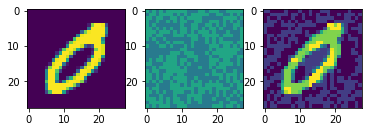

In [28]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(images.reshape(28, 28).detach().numpy())
plt.subplot(1, 3, 2)
plt.imshow((champ*EPS).reshape(28, 28).detach().numpy(), vmin=-1., vmax=1.)
plt.subplot(1, 3, 3)
plt.imshow(new_images.reshape(28, 28).detach().numpy())
plt.show()
